<h3>Kernel Density Estimation</h3>

This section will use the Kernel Density Estimation (KDE) methods to identify locations in San Francisco (SF) that see the highest amount of bike crashes. The KDE method combined with GeoPandas will help visualize crash hotspots around SF. 

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from math import radians
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from shapely.geometry import Point

In [4]:
crashes = pd.read_csv("data/Crashes.csv")
crashes = crashes.dropna(subset=['POINT_X', 'POINT_Y'])

In [5]:
#Cleaning data set so that latitudinal and longitudinal outliers are ignored
crashes_clean = crashes[
    (crashes['POINT_X'] > -123) & (crashes['POINT_X'] < -121) &  # reasonable longitudes
    (crashes['POINT_Y'] > 37)   & (crashes['POINT_Y'] < 38.5) ].copy()   # reasonable latitudes

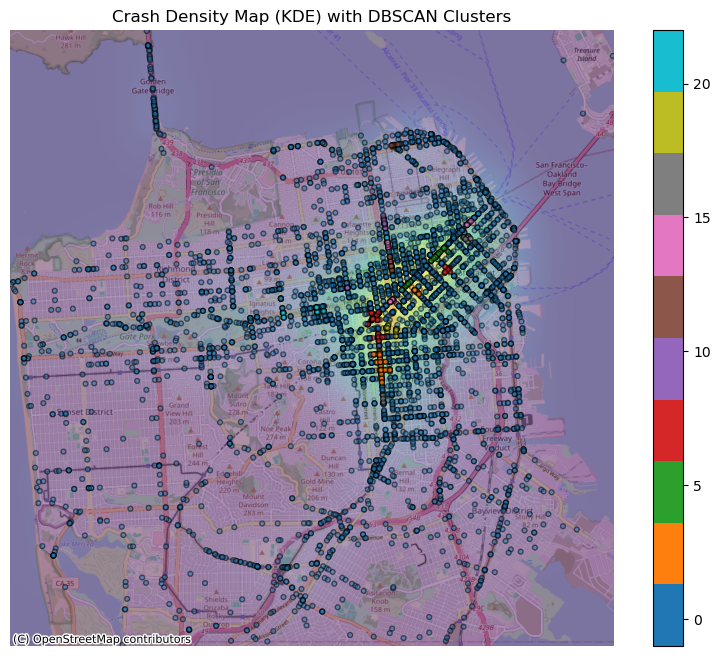

In [6]:
# Turn latitude and longitude into radians for the DBSCAN Haversine method
crashes_clean['lat_rad'] = crashes_clean['POINT_Y'].apply(radians)
crashes_clean['lon_rad'] = crashes_clean['POINT_X'].apply(radians)
coords_rad = crashes_clean[['lat_rad', 'lon_rad']].values

# Mark radius of the cluster
eps_meters = 100
eps_radians = eps_meters / 6371000.0

#Run DBSCAN, defining how many crashes will be in a cluster, noting haversine method
db = DBSCAN(
    eps=eps_radians,
    min_samples=20,
    metric='haversine'
).fit(coords_rad)  

#Set cluster IDs
crashes_clean['cluster'] = db.labels_

# Build points given geometry of crashes
crashes_clean['geometry'] = crashes_clean.apply(
    lambda row: Point(row['POINT_X'], row['POINT_Y']),
    axis=1 )

# Get geodata frame to plot on map
gdf = gpd.GeoDataFrame(crashes_clean, geometry='geometry', crs='EPSG:4326')

# Reproject to turn from radians into meters for map
gdf = gdf.to_crs(epsg=3857)

# Get projected points for KDE analysis
x = gdf.geometry.x.values
y = gdf.geometry.y.values

# Build grid over study area for eventual figure and KDE density surface
xmin, ymin, xmax, ymax = gdf.total_bounds
xi, yi = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]

# Run KDE
kde = gaussian_kde([x, y]) 
zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
zi = zi.reshape(xi.shape)

# Figure with clusters, mesh, and underlying map
fig, ax = plt.subplots(figsize=(10, 8))

ax.pcolormesh(xi, yi, zi, shading='auto', cmap='viridis', alpha=0.45)

# Points colored by cluster label
gdf.plot(
    ax=ax,
    column='cluster',
    cmap='tab10',
    markersize=12,
    alpha=0.5,
    edgecolor='black',
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Crash Density Map (KDE) with DBSCAN Clusters")
plt.show()


Now, lets just look at fatal crashes

In [7]:
crashes_clean.columns

Index(['CASE_ID', 'ACCIDENT_YEAR', 'PROC_DATE', 'JURIS', 'COLLISION_DATE',
       'COLLISION_TIME', 'OFFICER_ID', 'REPORTING_DISTRICT', 'DAY_OF_WEEK',
       'CHP_SHIFT', 'POPULATION', 'CNTY_CITY_LOC', 'SPECIAL_COND', 'BEAT_TYPE',
       'CHP_BEAT_TYPE', 'CITY_DIVISION_LAPD', 'CHP_BEAT_CLASS', 'BEAT_NUMBER',
       'PRIMARY_RD', 'SECONDARY_RD', 'DISTANCE', 'DIRECTION', 'INTERSECTION',
       'WEATHER_1', 'WEATHER_2', 'STATE_HWY_IND', 'CALTRANS_COUNTY',
       'CALTRANS_DISTRICT', 'STATE_ROUTE', 'ROUTE_SUFFIX', 'POSTMILE_PREFIX',
       'POSTMILE', 'LOCATION_TYPE', 'RAMP_INTERSECTION', 'SIDE_OF_HWY',
       'TOW_AWAY', 'COLLISION_SEVERITY', 'NUMBER_KILLED', 'NUMBER_INJURED',
       'PARTY_COUNT', 'PRIMARY_COLL_FACTOR', 'PCF_CODE_OF_VIOL',
       'PCF_VIOL_CATEGORY', 'PCF_VIOLATION', 'PCF_VIOL_SUBSECTION',
       'HIT_AND_RUN', 'TYPE_OF_COLLISION', 'MVIW', 'PED_ACTION',
       'ROAD_SURFACE', 'ROAD_COND_1', 'ROAD_COND_2', 'LIGHTING',
       'CONTROL_DEVICE', 'CHP_ROAD_TYPE', 'PEDESTRIAN_

In [8]:
crashes_fatal = crashes_clean[crashes_clean['COLLISION_SEVERITY'] == 1]


/tmp/ipykernel_215/1853195783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_fatal['lat_rad'] = crashes_fatal['POINT_Y'].apply(radians)
/tmp/ipykernel_215/1853195783.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_fatal['lon_rad'] = crashes_fatal['POINT_X'].apply(radians)
/tmp/ipykernel_215/1853195783.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

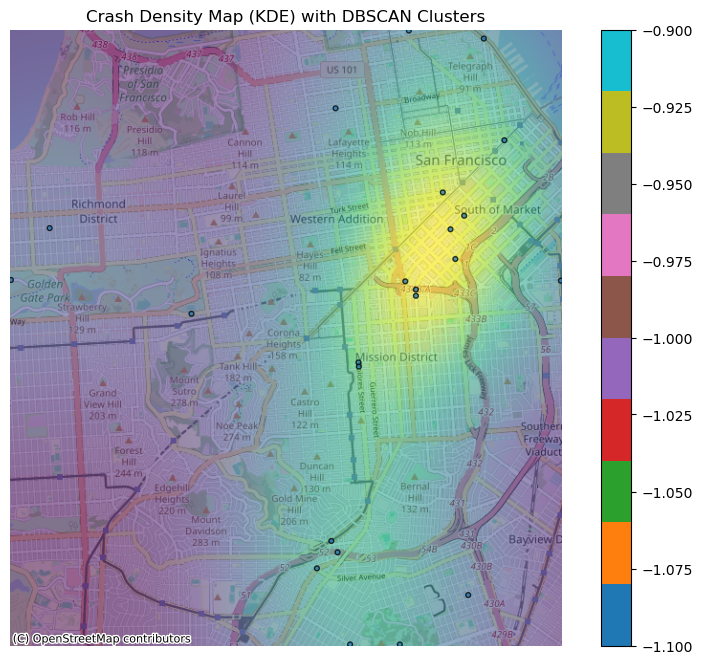

In [9]:
# Turn latitude and longitude into radians for the DBSCAN Haversine method
crashes_fatal['lat_rad'] = crashes_fatal['POINT_Y'].apply(radians)
crashes_fatal['lon_rad'] = crashes_fatal['POINT_X'].apply(radians)
coords_rad = crashes_fatal[['lat_rad', 'lon_rad']].values

# Mark radius of the cluster
eps_meters = 200
eps_radians = eps_meters / 6371000.0

#Run DBSCAN, defining how many crashes will be in a cluster, noting haversine method
db = DBSCAN(
    eps=eps_radians,
    min_samples=3,
    metric='haversine'
).fit(coords_rad)  

#Set cluster IDs
crashes_fatal['cluster'] = db.labels_

# Build points given geometry of crashes
crashes_fatal['geometry'] = crashes_fatal.apply(
    lambda row: Point(row['POINT_X'], row['POINT_Y']),
    axis=1 )

# Get geodata frame to plot on map
gdf = gpd.GeoDataFrame(crashes_fatal, geometry='geometry', crs='EPSG:4326')

# Reproject to turn from radians into meters for map
gdf = gdf.to_crs(epsg=3857)

# Get projected points for KDE analysis
x = gdf.geometry.x.values
y = gdf.geometry.y.values

# Build grid over study area for eventual figure and KDE density surface
xmin, ymin, xmax, ymax = gdf.total_bounds
xi, yi = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]

# Run KDE
kde = gaussian_kde([x, y]) 
zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
zi = zi.reshape(xi.shape)

# Figure with clusters, mesh, and underlying map
fig, ax = plt.subplots(figsize=(10, 8))

ax.pcolormesh(xi, yi, zi, shading='auto', cmap='viridis', alpha=0.55)

# Points colored by cluster label
gdf.plot(
    ax=ax,
    column='cluster',
    cmap='tab10',
    markersize=12,
    alpha=0.75,
    edgecolor='black',
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Crash Density Map (KDE) with DBSCAN Clusters")
plt.show()


We will need to look at proportions of crashes that occur in each aream but maybe also we can look at physical attributes

In [10]:
crashes_fatsevere = crashes_clean[crashes_clean['COLLISION_SEVERITY'] <= 2]

/tmp/ipykernel_215/4170574192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_fatsevere['lat_rad'] = crashes_fatsevere['POINT_Y'].apply(radians)
/tmp/ipykernel_215/4170574192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_fatsevere['lon_rad'] = crashes_fatsevere['POINT_X'].apply(radians)
/tmp/ipykernel_215/4170574192.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

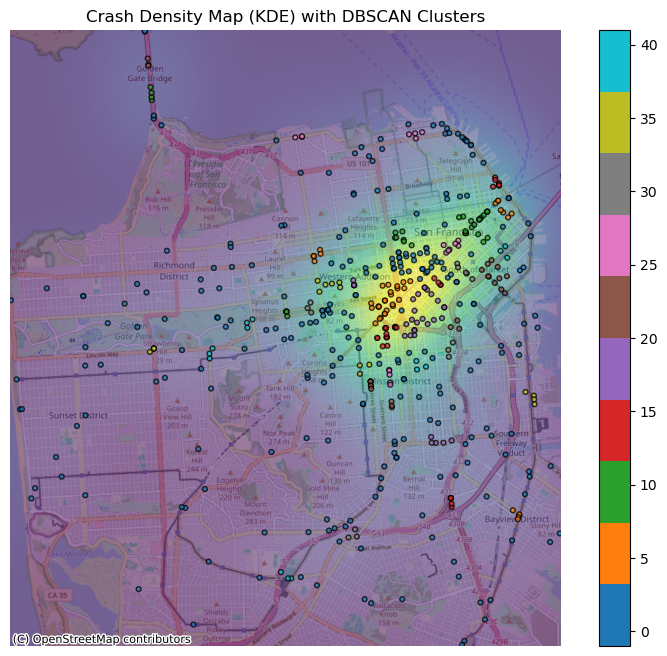

In [11]:
# Turn latitude and longitude into radians for the DBSCAN Haversine method
crashes_fatsevere['lat_rad'] = crashes_fatsevere['POINT_Y'].apply(radians)
crashes_fatsevere['lon_rad'] = crashes_fatsevere['POINT_X'].apply(radians)
coords_rad = crashes_fatsevere[['lat_rad', 'lon_rad']].values

# Mark radius of the cluster
eps_meters = 200
eps_radians = eps_meters / 6371000.0

#Run DBSCAN, defining how many crashes will be in a cluster, noting haversine method
db = DBSCAN(
    eps=eps_radians,
    min_samples=3,
    metric='haversine'
).fit(coords_rad)  

#Set cluster IDs
crashes_fatsevere['cluster'] = db.labels_

# Build points given geometry of crashes
crashes_fatsevere['geometry'] = crashes_fatsevere.apply(
    lambda row: Point(row['POINT_X'], row['POINT_Y']),
    axis=1 )

# Get geodata frame to plot on map
gdf = gpd.GeoDataFrame(crashes_fatsevere, geometry='geometry', crs='EPSG:4326')

# Reproject to turn from radians into meters for map
gdf = gdf.to_crs(epsg=3857)

# Get projected points for KDE analysis
x = gdf.geometry.x.values
y = gdf.geometry.y.values

# Build grid over study area for eventual figure and KDE density surface
xmin, ymin, xmax, ymax = gdf.total_bounds
xi, yi = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]

# Run KDE
kde = gaussian_kde([x, y]) 
zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
zi = zi.reshape(xi.shape)

# Figure with clusters, mesh, and underlying map
fig, ax = plt.subplots(figsize=(10, 8))

ax.pcolormesh(xi, yi, zi, shading='auto', cmap='viridis', alpha=0.55)

# Points colored by cluster label
gdf.plot(
    ax=ax,
    column='cluster',
    cmap='tab10',
    markersize=12,
    alpha=0.75,
    edgecolor='black',
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Crash Density Map (KDE) with DBSCAN Clusters")
plt.show()


I want to see fatal and severe crashes 2020 or later because Market Street closed to cars Jan 29, 2020

In [15]:
fatalsevere_recent = crashes_fatsevere[crashes_fatsevere['ACCIDENT_YEAR'] >= 2020]
fatalsevere_recent[fatalsevere_recent['ACCIDENT_YEAR'] == 2020]

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y,lat_rad,lon_rad,cluster,geometry
366,9194278,2020,2021-01-21,3801,2020-11-14,1613,2408,MISSI,6,5,...,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.434998,37.762810,0.659085,-2.136894,-1,POINT (-122.43499755859376 37.76280975341797)
746,9058036,2020,2020-09-25,3801,2020-03-13,1203,1332,NORTH,5,5,...,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.419632,37.777317,0.659339,-2.136626,5,POINT (-122.4196319580078 37.77731704711913)
757,9120880,2020,2020-09-14,3801,2020-06-05,715,2310,NORTH,5,5,...,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.419678,37.777721,0.659346,-2.136626,5,POINT (-122.419677734375 37.7777214050293)
760,91236862,2020,2020-05-12,9350,2020-05-06,1910,022066,NaN,3,2,...,37.809158,-122.477333,SAN FRANCISCO,SAN FRANCISCO,-122.477425,37.809120,0.659894,-2.137634,-1,POINT (-122.47742462158205 37.809120178222656)
761,91327338,2020,2020-10-20,9350,2020-10-14,1821,020979,NaN,3,2,...,37.820381,-122.478760,SAN FRANCISCO,SAN FRANCISCO,-122.478851,37.820370,0.660090,-2.137659,21,POINT (-122.47885131835938 37.82036972045898)
1540,9047549,2020,2020-03-06,3801,2020-01-31,1305,2743,SOUTH,5,5,...,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.415909,37.775280,0.659303,-2.136561,18,POINT (-122.41590881347656 37.7752799987793)
1556,9092195,2020,2021-08-03,3801,2020-02-01,1034,1730,TRAFF,6,5,...,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.500580,37.745689,0.658787,-2.138038,-1,POINT (-122.50057983398438 37.74568939208984)
1569,9120785,2020,2020-08-26,3801,2020-06-12,1825,4132,MISSI,5,5,...,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.413147,37.765450,0.659131,-2.136512,-1,POINT (-122.41314697265624 37.765449523925774)
1585,9138930,2020,2020-10-09,3801,2020-07-31,2116,2457,SOUTH,5,5,...,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.422623,37.772549,0.659255,-2.136678,5,POINT (-122.42262268066406 37.77254867553711)
1589,9145187,2020,2020-10-13,3801,2020-08-13,2202,983,BAYVI,4,5,...,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.383293,37.743996,0.658757,-2.135991,-1,POINT (-122.38329315185548 37.74399566650391)


/tmp/ipykernel_215/1158195393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fatalsevere_recent['lat_rad'] = fatalsevere_recent['POINT_Y'].apply(radians)
/tmp/ipykernel_215/1158195393.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fatalsevere_recent['lon_rad'] = fatalsevere_recent['POINT_X'].apply(radians)
/tmp/ipykernel_215/1158195393.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

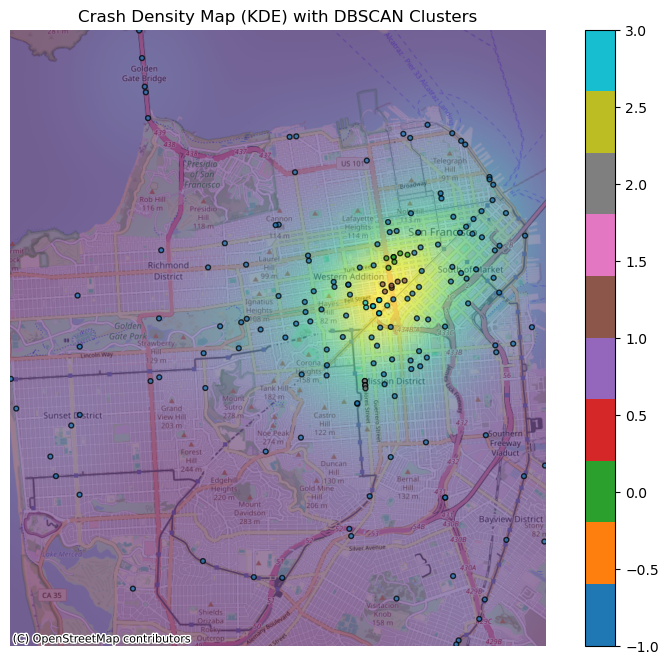

In [13]:
# Turn latitude and longitude into radians for the DBSCAN Haversine method
fatalsevere_recent['lat_rad'] = fatalsevere_recent['POINT_Y'].apply(radians)
fatalsevere_recent['lon_rad'] = fatalsevere_recent['POINT_X'].apply(radians)
coords_rad = fatalsevere_recent[['lat_rad', 'lon_rad']].values

# Mark radius of the cluster
eps_meters = 200
eps_radians = eps_meters / 6371000.0

#Run DBSCAN, defining how many crashes will be in a cluster, noting haversine method
db = DBSCAN(
    eps=eps_radians,
    min_samples=4,
    metric='haversine'
).fit(coords_rad)  

#Set cluster IDs
fatalsevere_recent['cluster'] = db.labels_

# Build points given geometry of crashes
fatalsevere_recent['geometry'] = fatalsevere_recent.apply(
    lambda row: Point(row['POINT_X'], row['POINT_Y']),
    axis=1 )

# Get geodata frame to plot on map
gdf = gpd.GeoDataFrame(fatalsevere_recent, geometry='geometry', crs='EPSG:4326')

# Reproject to turn from radians into meters for map
gdf = gdf.to_crs(epsg=3857)

# Get projected points for KDE analysis
x = gdf.geometry.x.values
y = gdf.geometry.y.values

# Build grid over study area for eventual figure and KDE density surface
xmin, ymin, xmax, ymax = gdf.total_bounds
xi, yi = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]

# Run KDE
kde = gaussian_kde([x, y]) 
zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
zi = zi.reshape(xi.shape)

# Figure with clusters, mesh, and underlying map
fig, ax = plt.subplots(figsize=(10, 8))

ax.pcolormesh(xi, yi, zi, shading='auto', cmap='viridis', alpha=0.55)

# Points colored by cluster label
gdf.plot(
    ax=ax,
    column='cluster',
    cmap='tab10',
    markersize=12,
    alpha=0.75,
    edgecolor='black',
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Crash Density Map (KDE) with DBSCAN Clusters")
plt.show()